In [39]:
import numpy as np
import mne
import pyxdf
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

from util import preprocess_util

DATA_DIR = Path('./data')
DATA_FILE_NAME = 'Sandra_MI_1h.xdf'
DATA_FILE = DATA_DIR / DATA_FILE

# Read in xdf file(s)

In [33]:
# Read data
streams, header = pyxdf.load_xdf(DATA_FILE)

In [3]:
# Extract streams from xdf data

def find_stream(name, streams):
    for stream in streams:
        if stream['info']['name'][0] == name:
            return stream
    
    print(f'Error: stream "{name}" not found')

unicorn_stream = find_stream('Unicorn', streams)
fs = int(unicorn_stream['info']['nominal_srate'][0]) # 250 Hz

openvibe_stream = find_stream('openvibeMarkers', streams)
openvibe_stream['time_series'] = np.array(openvibe_stream['time_series'])

print(f"EEG data shape: {unicorn_stream['time_series'].shape}")
print(f"Markers shape: {openvibe_stream['time_series'].shape}")
print(f'Sampling Frequency: {fs}')

EEG data shape: (1023780, 17)
Markers shape: (1213, 1)
Sampling Frequency: 250


# Extract Event Data

From the Open Vibe Marker Stream

- `event_codes`: array of codes sent to the marker stream at the start of each event 
- `event_time_stamps`: array of timestamps signifying the start of each event

The mapping for this particular paradigm was:
- 'beep': 0, 
- 'cue_no_blink': 1, 
- 'imagery_no_blink': 2, 
- 'break': 3, 
- 'cue_handR': 4, 
- 'imagery_handR': 5, 
- 'cue_handL': 6, 
- 'imagery_handL': 7

In [8]:
def unique(input_list):
    unique_items = []
    for x in input_list:
        if x not in unique_items:
            unique_items.append(x)
    
    return unique_items

def build_unique_mapping(unique_labels):
    unique_mapping = {}
    for i, label in enumerate(unique_labels):
        unique_mapping[label] = i
    
    return unique_mapping

In [9]:
# Get event codes
event_labels = [x[0] for x in openvibe_stream['time_series']]
unique_labels = unique(event_labels)
label2code = build_unique_mapping(unique_labels)
event_codes = np.array([label2code[x] for x in event_labels])

# Get event time stamps
event_time_stamps = np.array(openvibe_stream['time_stamps'])

print(f'Number of event codes: {event_codes.shape}')
print(f'Number of event timestamps: {event_time_stamps.shape}')

Number of event codes: (1213,)
Number of event timestamps: (1213,)


# Preprocess EEG data

In [10]:
def channel2name(channel_number):
    mapping = {
        0:  'Fz',    
        1:  'C3', 
        2:  'Cz', 
        3:  'C4',
        4:  'Pz', 
        5:  'PO7', 
        6:  'Oz', 
        7:  'PO8',
    }
    return mapping[channel_number]

def name2channel(name):
    mapping = {
        'Fz': 0,    
        'C3': 1, 
        'Cz': 2, 
        'C4': 3,
        'Pz': 4, 
        'PO7': 5,
        'Oz': 6, 
        'PO8': 7,
    }
    return mapping[name]

def get_channel(channel_name:str, eeg_data):
    '''
    Params:
        - channel_name: One of [Fz, C3, Cz, C4, Pz, P07, Oz, PO8]
        - eeg_data: shape (num_channels, num_samples)
    Returns:
        - single channel
    '''
    return eeg_data[name2channel[channel_name], :]


In [11]:
# Extract the relevent EEG channels
eeg_data = unicorn_stream['time_series'][:,0:8].T
eeg_data.shape

(8, 1023780)

## Rereference the EEG data

In [12]:
# Rereference
eeg_data = eeg_data - np.mean(eeg_data, axis=0)

## Filter EEG data

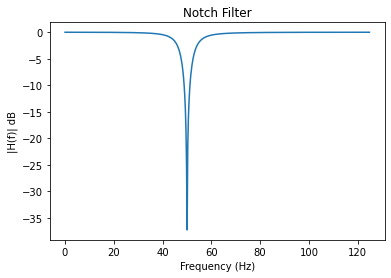

In [13]:
lf = 2
hf = 30
nf = 50

# Design notch filter
b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

# Plot the notch filter TF
plt.figure()
plt.plot( freq, 20*np.log10(abs(h)))
plt.title('Notch Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(f)| dB')
plt.show()

# Apply notch and bandpass filters
eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess_util.bandpass(eeg_notched, lf=lf, hf=hf, fs=fs, ftype='iir')

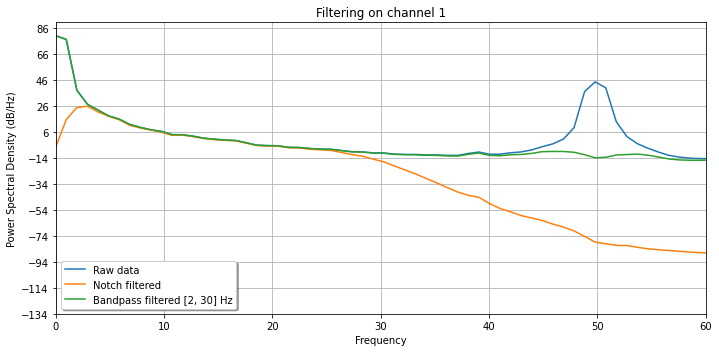

In [14]:
channel_number = name2channel('C3')

# Show the effect of the filter
plt.figure(figsize=(10,5))
plt.title(f'Filtering on channel {channel_number}')
plt.psd(eeg_data[channel_number], Fs=fs, label='Raw data')
plt.psd(eeg_notched_bp[channel_number], Fs=fs, label='Notch filtered')
plt.psd(eeg_notched[channel_number], Fs=fs, label=f'Bandpass filtered [{lf}, {hf}] Hz')
plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

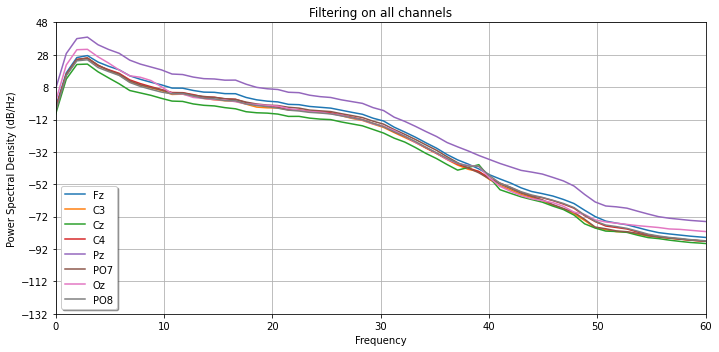

In [15]:
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

# Build an event time-series/stream

Create a time series from the event codes which is the same length as the EEG data

In [16]:
eeg_timestamps = unicorn_stream['time_stamps']
eeg_start_time = eeg_timestamps[0]
label_start_time = event_time_stamps[0]
experiment_start_time = min(label_start_time, eeg_start_time)

relative_eeg_timestamps = eeg_timestamps - experiment_start_time
relative_event_time_stamps = event_time_stamps - experiment_start_time

In [17]:
def find_closest_time(timestamp, eeg_timestamps):
    return np.where(eeg_timestamps > timestamp)[0][0]

In [18]:
# Get indices of events
indices = [0]

for timestamp in relative_event_time_stamps:
    indices.append(find_closest_time(timestamp, relative_eeg_timestamps))

# Build event time series (use -1 since 0 is actually a code for no blinking)
event_time_series = np.zeros_like(eeg_timestamps) - 1

for i, (_, code) in enumerate(zip(indices[1:], event_codes)):
    idx = i+1
    if idx < len(indices)-1:
        event_time_series[indices[idx]:indices[idx+1]] = code
    else:
        event_time_series[indices[idx]:] = code

In [19]:
indices[0:10]

[0, 1136, 1385, 1882, 2880, 3882, 4378, 5375, 6373, 6870]

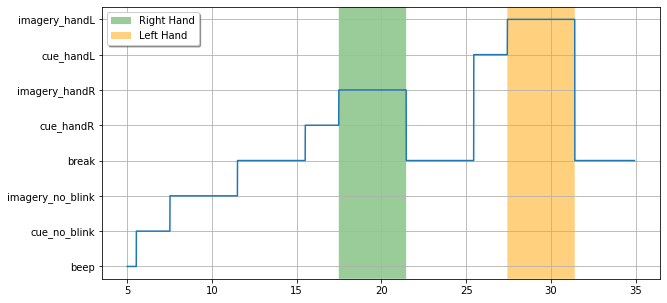

In [26]:
window = 30
start_time = 5
t = np.arange(0, window*fs, 1/fs)

fig, ax = plt.subplots(figsize=(10,5))
x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y = event_time_series[start_time*fs:(start_time + window)*fs]
ax.plot(x, y, '-')

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(x, 0, 1, where= (y == 5),
                facecolor='green', alpha=0.4, transform=trans, label='Right Hand')
ax.fill_between(x, 0, 1, where= (y == 7),
                facecolor='orange', alpha=0.5, transform=trans, label='Left Hand')

event_labels = list(label2code.keys())
plt.yticks(range(len(event_labels)), event_labels)
plt.grid()
plt.legend(shadow=True)
plt.show()

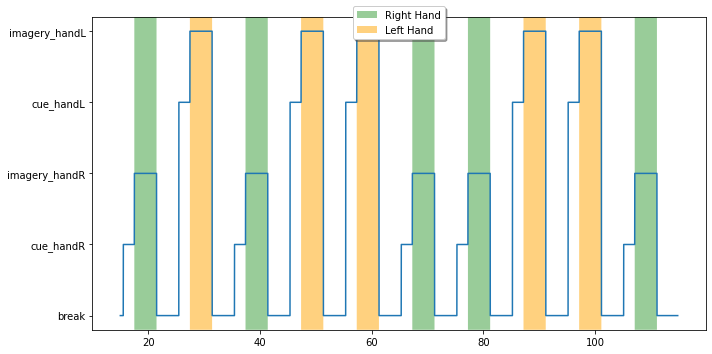

In [21]:
window = 100
start_time = 15
x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y = event_time_series[start_time*fs:(start_time + window)*fs]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(x, 0, 1, where= (y == 5),
                facecolor='green', alpha=0.4, transform=trans, label='Right Hand')
ax.fill_between(x, 0, 1, where= (y == 7),
                facecolor='orange', alpha=0.5, transform=trans, label='Left Hand')

event_labels = list(label2code.keys())
plt.yticks(range(len(event_labels)), event_labels)
plt.ylim([2.8,7.2])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), shadow=True, fancybox=True)
plt.tight_layout()
plt.show()

# Inspect EEG data with markers

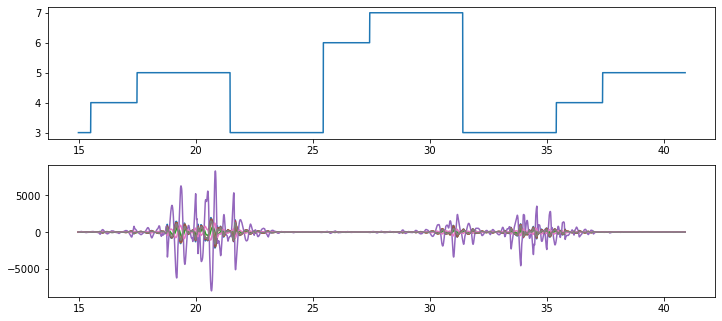

In [22]:
window = 26
start_time = 15
number_of_channels = 8

plt.subplots(figsize=(10,20), sharex=True)
plt.tight_layout()

x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y1 = event_time_series[start_time*fs:(start_time + window)*fs]
plt.subplot((number_of_channels + 1),1,1)
plt.plot(x, y1)

for i in range(number_of_channels):
    y2 = eeg_notched_bp[i ,start_time*fs:(start_time + window)*fs]
    plt.subplot((number_of_channels + 1), 1, 2)
    plt.plot(x, y2)

plt.show()

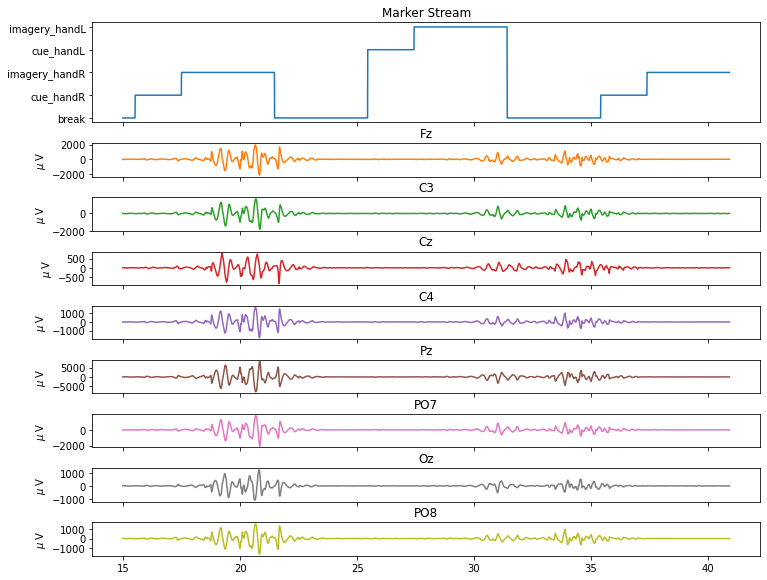

In [24]:
colors = plt.rcParams["axes.prop_cycle"]()

window = 26
start_time = 15
number_of_channels = 8

fig, axs = plt.subplots(number_of_channels+1, 1,figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [3,1,1,1,1,1,1,1,1]})
plt.tight_layout()

x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y = event_time_series[start_time*fs:(start_time + window)*fs]

c = next(colors)["color"]
axs[0].plot(x, y, color=c)
axs[0].set_title('Marker Stream')
plt.sca(axs[0])
plt.yticks(range(len(event_labels)), event_labels)
axs[0].set_ylim([2.8,7.2])

for i in range(number_of_channels):
    axs[i+1].plot(
        x, 
        eeg_notched_bp[i ,start_time*fs:(start_time + window)*fs], 
        color=next(colors)["color"]
    )
    axs[i+1].set_title(channel2name(i))
    axs[i+1].set_ylabel(r'$\mu$ V')

plt.show()

# Save the data

In [46]:
data_file_name = DATA_FILE_NAME.split('.')[0]
np.save(DATA_DIR / f'{data_file_name}_eeg_data', eeg_notched_bp, allow_pickle=True)
np.save(DATA_DIR / f'{data_file_name}_marker_stream', eeg_notched_bp, allow_pickle=True)

# Split into trials

# Normalise EEG data 